In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd

from collections import defaultdict
from scipy.special import softmax
from tqdm import notebook

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

In [2]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [3]:
env = BlackjackEnv(natural=True)
env.action_space

Discrete(2)

In [4]:
help(env)

Help on BlackjackEnv in module __main__ object:

class BlackjackEnv(gym.core.Env)
 |  BlackjackEnv(natural=False)
 |  
 |  Simple blackjack environment
 |  Blackjack is a card game where the goal is to obtain cards that sum to as
 |  near as possible to 21 without going over.  They're playing against a fixed
 |  dealer.
 |  Face cards (Jack, Queen, King) have point value 10.
 |  Aces can either count as 11 or 1, and it's called 'usable' at 11.
 |  This game is placed with an infinite deck (or with replacement).
 |  The game starts with dealer having one face up and one face down card, while
 |  player having two face up cards. (Virtually for all Blackjack games today).
 |  The player can request additional cards (hit=1) until they decide to stop
 |  (stick=0) or exceed 21 (bust).
 |  After the player sticks, the dealer reveals their facedown card, and draws
 |  until their sum is 17 or greater.  If the dealer goes bust the player wins.
 |  If neither player nor dealer busts, the outcom

In [5]:
observation = env.reset()
observation

(14, 3, False)

Observation tuple for Blackjack:

sum of players cards (ace counts 11) \
sum of dealers cards \
player has useable ace 

0: stay \
1: hit

Returns: \
 |          observation (object): agent's observation of the current environment \
 |          reward (float) : amount of reward returned after previous action \
 |          done (bool): whether the episode has ended, in which case further step() calls will return undefined 

In [6]:
observation, reward, done, info = env.step(0)
observation, reward, done, info 

((14, 3, False), 1.0, True, {})

In [7]:
def train_q_learning_policy(env, n_games, alpha, gamma):
    """
    Q-learning training
    """
    rewards = []
    local_est = []
    
    policy = QPolicy(env.action_space.n)
    
    for i in notebook.tqdm(range(n_games)):
        observation = env.reset()
        
        while True:
            action = policy.action(observation, train_mode=True)
            next_observation, reward, done, _ = env.step(action)
            
            next_action = policy.action(next_observation, train_mode=False)
            policy.opt_step(observation, action, reward, next_observation, next_action, alpha, gamma)
            
            if done:
                rewards.append(reward)
                break
            observation = next_observation
            
        if i % 100000 == 0:
            local_est.append((i, policy_estimation(env, policy, 100000)))
            
    return policy, rewards, local_est

def plot_train_reward(rewards, local_est):
    """
    Result visualisation
    """
    plt.figure(figsize=(17, 7))
    plt.plot(pd.Series(rewards).rolling(5000).mean())
    local_est_ = list(zip(*local_est))
    plt.plot(*local_est_)
    
    plt.xlabel("Iteration", fontsize=20)
    plt.ylabel("Reward", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(["Train Reward", "Test Reward"], fontsize=15)
    plt.show()
    
    
def policy_estimation(env, policy, n_games):
    """
    Policy gain estimation
    """
    gains_sum = 0
    for _ in range(n_games):
        observation = env.reset()
        while True:
            action = policy.action(observation)
            observation, reward, done, _ = env.step(action)
            if done:
                gains_sum += reward
                break

    mean_reward = gains_sum / n_games
    return mean_reward

### Часть первая, с блекджеком и стратегиями

In [8]:
class TrivialPolicy:
    def action(self, observation):
        if observation[0] >= 19:
            return 0
        else:
            return 1

In [9]:
# оценка среднего дохода тривиальной стратегии по набору игр

policy_estimation(env, TrivialPolicy(), 1000000)

-0.180182

#### Q-learning

In [10]:
class QPolicy:
    np.random.seed(42)
    def __init__(self, n_actions):
        self.__q_function = defaultdict(lambda: (1 / n_actions) * np.ones(n_actions))
        
    def action(self, observation, train_mode=False):
        if train_mode:
            p_ = self.__q_function[observation]
            return np.random.choice(np.arange(p_.shape[0]), p=softmax(p_)) # аналог e-greedy
        else:
            return np.argmax(self.__q_function[observation])
    
    def opt_step(self, observation, action, reward, next_observation, next_action, alpha, gamma):
        target_reward = reward + gamma * self.__q_function[next_observation][next_action]
        diff_reward = target_reward - self.__q_function[observation][action]
        self.__q_function[observation][action] = self.__q_function[observation][action] + alpha * diff_reward

In [11]:
q_learning_policy, rewards, local_est = train_q_learning_policy(env, 1000000, 0.00125, 0.2)

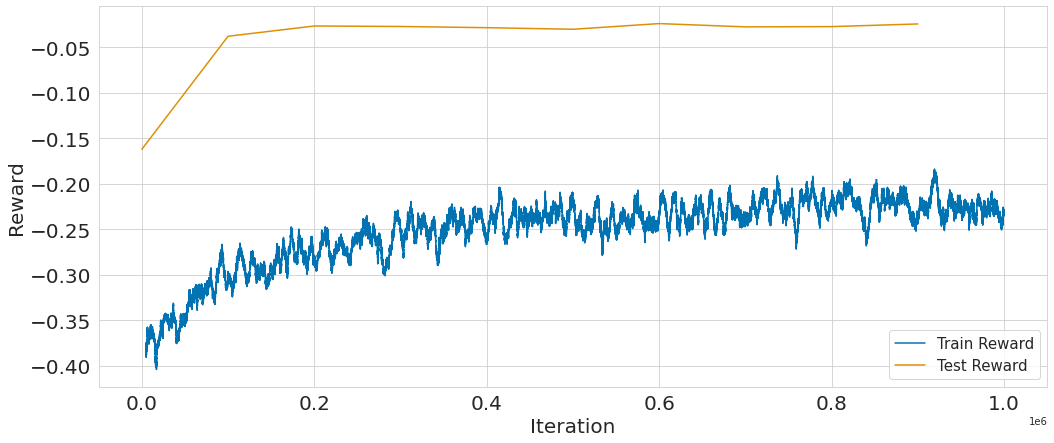

In [12]:
plot_train_reward(rewards, local_est)

In [13]:
# оценка среднего дохода стратегии (Q-learning) по набору игр без удвоения ставки

policy_estimation(env, q_learning_policy, 1000000)

-0.0245975

### Часть вторая, удвоенная

In [14]:
class BlackjackDoubleEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.action_space.n = 3
        
    def step(self, action):
        if action == 2:
            super().step(1)
            observation, reward, done, info = super().step(0)
            assert done == True
            return observation + ("double", ), 2*reward, True, info
        else:
            return super().step(action)

In [15]:
double_env = BlackjackDoubleEnv(natural=True)

In [16]:
q_learning_policy_d, rewards, local_est = train_q_learning_policy(double_env, 1000000, 0.00125, 0.2)

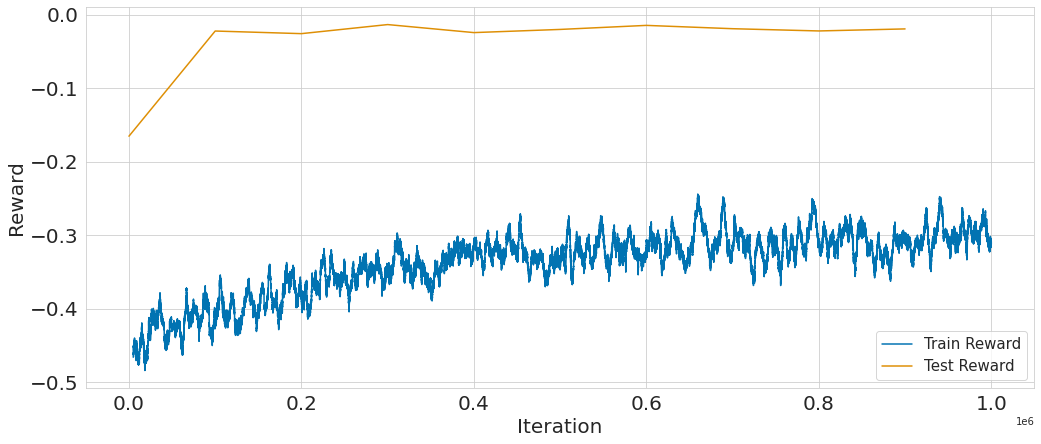

In [17]:
plot_train_reward(rewards, local_est)

In [18]:
# оценка среднего дохода стратегии (Q-learning) по набору игр с возможностью удвоения ставки

policy_estimation(double_env, q_learning_policy_d, 1000000)

-0.021599

### Часть третья, в главной роли — Дастин Хоффман

In [19]:
card2score = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}

def card_count_function(local_deck):
    return sum(map(lambda x: card2score[x], local_deck))

class BlackjackEnvCount(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.__deck = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10) * 4
        self.__local_deck = []
        
    def new_card_deck(self):
        self.__local_deck = list(self.__deck)
        np.random.shuffle(self.__local_deck)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.__local_deck.pop())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.__local_deck.pop())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0],
                usable_ace(self.player), card_count_function(self.__local_deck))

    def reset(self):
        if len(self.__local_deck) < 15:
            self.new_card_deck()
        
        self.dealer = [self.__local_deck.pop()]
        self.player = [self.__local_deck.pop()]
        return self._get_obs()
    
class BlackjackDoubleEnvCount(BlackjackEnvCount):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.action_space.n = 3
        
    def step(self, action):
        if action == 2:
            super().step(1)
            observation, reward, done, info = super().step(0)
            assert done == True
            return observation + ("double", ), 2*reward, True, info
        else:
            return super().step(action)

In [20]:
double_env_c = BlackjackDoubleEnvCount(natural=True)

In [21]:
q_learning_policy_d_c, rewards, local_est = train_q_learning_policy(double_env_c, 1000000, 0.002, 0.7)

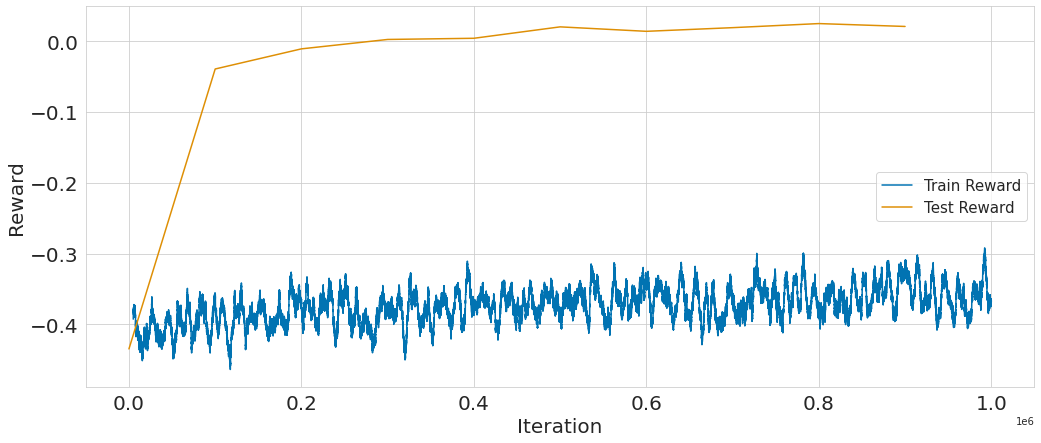

In [22]:
plot_train_reward(rewards, local_est)

In [23]:
# оценка среднего дохода стратегии (Q-learning) по набору игр с возможностью удвоения ставки
# и возможностью считать карты 

policy_estimation(double_env_c, q_learning_policy_d_c, 1000000)

0.023615